## Model Fitting and Evaluation

In [2]:
import pipeline
import pandas as pd
import numpy as np
import importlib
importlib.reload(pipeline)

<module 'pipeline' from '/Users/piyushtank/Dropbox/mscapp/spring_20/machine_learning/project/covid/git/ml-covid/scripts/pipeline.py'>

In [7]:
filepath = '../data/covid_df_protocol_3.pkl'
df = pd.read_pickle(filepath)
df['log_cases'] = np.log(df['Deaths'] + 1)

### Validations

- Splitting by time (last 2 weeks as a test data and remaining earlier weeks for training the model)

In [9]:
# getting train and test dataframes
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df, 2)
#sanity chceck
pipeline.sanity_check(df_train, df_test)

Success: Features match
Success: No NAs remain


                           Feature  Coefficient
0                        Intercept     1.169714
19   Days Elapsed Since First Case     0.037368
8             EconomicSupportIndex     0.014982
18                       Day Count    -0.000150
149            Country_Switzerland     0.000000
..                             ...          ...
77                  Country_Guinea    -0.000000
78                   Country_Haiti    -0.000000
79                Country_Honduras     0.000000
80                 Country_Hungary     0.000000
215         H3_Contact tracing_2.0    -0.000000

[216 rows x 2 columns]


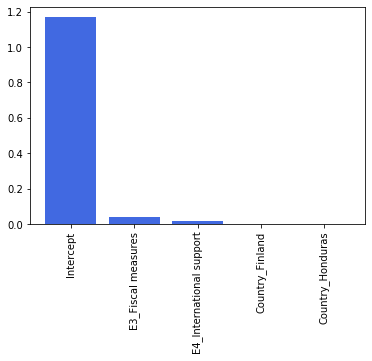

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.169714
19   Days Elapsed Since First Case     0.037368
8             EconomicSupportIndex     0.014982
18                       Day Count    -0.000150
149            Country_Switzerland     0.000000
139              Country_Singapore    -0.000000
140        Country_Slovak Republic    -0.000000
141               Country_Slovenia     0.000000
142           Country_South Africa     0.000000
143            Country_South Korea     0.000000

Bias: 2.70
Mean squared error: 5.75
RSS: 8753.19
Variance score: 0.51

R2 score: 0.24

                      Feature  Coefficient
0                   Intercept     3.870431
88              Country_Italy     2.395273
84               Country_Iran     2.026750
116       Country_New Zealand    -1.881869
166           Country_Vietnam    -1.768386
..                       

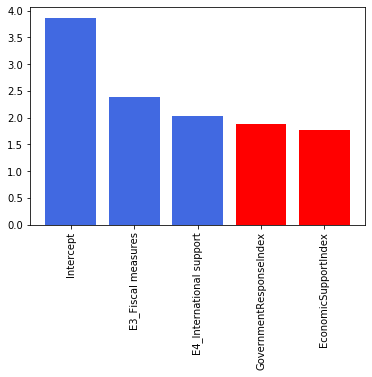

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept     3.870431
88           Country_Italy     2.395273
84            Country_Iran     2.026750
116    Country_New Zealand    -1.881869
166        Country_Vietnam    -1.768386
81         Country_Iceland    -1.582096
83       Country_Indonesia     1.509286
82           Country_India    -1.445238
144          Country_Spain     1.369132
203  E1_Income support_2.0     1.354695

Bias: 1.09
Mean squared error: 2.23
RSS: 3393.29
Variance score: 0.80

R2 score: 0.71

                           Feature  Coefficient
7           ContainmentHealthIndex  -973.760035
5                  StringencyIndex   904.162670
212          H2_Testing policy_3.0   136.372561
209          H2_Testing policy_0.0  -135.854217
213         H3_Contact tracing_0.0  -135.512430
..                             ...          ...
4        H5_Investment in vaccines 

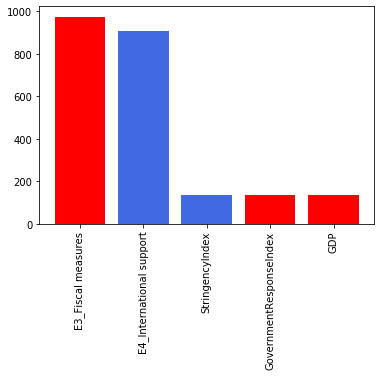

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex  -973.760035
5            StringencyIndex   904.162670
212    H2_Testing policy_3.0   136.372561
209    H2_Testing policy_0.0  -135.854217
213   H3_Contact tracing_0.0  -135.512430
215   H3_Contact tracing_2.0   135.400368
0                  Intercept    93.980836
6    GovernmentResponseIndex   -71.059344
210    H2_Testing policy_1.0   -45.740852
211    H2_Testing policy_2.0    45.222506

Bias: 1.08
Mean squared error: 2.19
RSS: 3325.70
Variance score: 0.81

R2 score: 0.71



In [10]:
# Getting Features and outcome variables
X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
results_dict = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)

In [12]:
# comparing the metrics for all three models
rs = pd.DataFrame(results_dict) 
rs['metrics']= ['Bias','MSE','RSS','Variance','R2']
rs.set_index('metrics')

,Lasso,Ridge,Linear Regression
metrics,,,
Bias,2.704552,1.088785,1.083034
MSE,5.754894,2.230959,2.186525
RSS,8753.194089,3393.288327,3325.704297
Variance,0.513742,0.804245,0.805279
R2,0.240668,0.705635,0.711498


#### Time Series Nested Cross Validation

Time series Nested Cross Validation is carried out with the following approach: 

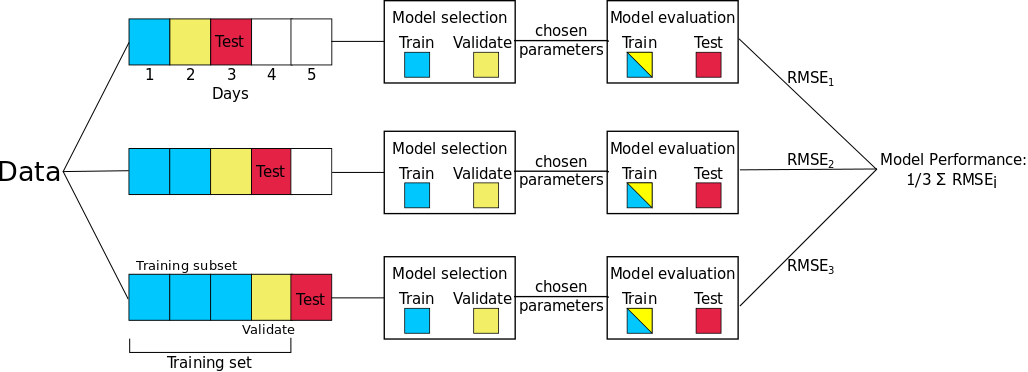

Cutting dataframe on date: 2020-06-02
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     1.169714
19   Days Elapsed Since First Case     0.037368
8             EconomicSupportIndex     0.014982
18                       Day Count    -0.000150
149            Country_Switzerland     0.000000
..                             ...          ...
77                  Country_Guinea    -0.000000
78                   Country_Haiti    -0.000000
79                Country_Honduras     0.000000
80                 Country_Hungary     0.000000
215         H3_Contact tracing_2.0    -0.000000

[216 rows x 2 columns]


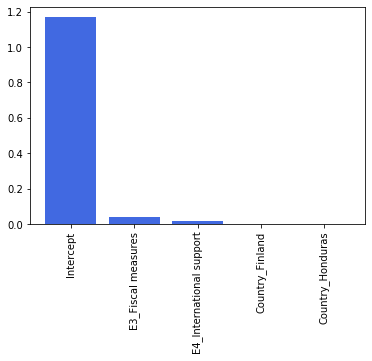

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.169714
19   Days Elapsed Since First Case     0.037368
8             EconomicSupportIndex     0.014982
18                       Day Count    -0.000150
149            Country_Switzerland     0.000000
139              Country_Singapore    -0.000000
140        Country_Slovak Republic    -0.000000
141               Country_Slovenia     0.000000
142           Country_South Africa     0.000000
143            Country_South Korea     0.000000

Bias: 2.70
Mean squared error: 5.75
RSS: 8753.19
Variance score: 0.51

R2 score: 0.24

                      Feature  Coefficient
0                   Intercept     3.870431
88              Country_Italy     2.395273
84               Country_Iran     2.026750
116       Country_New Zealand    -1.881869
166           Country_Vietnam    -1.768386
..                       

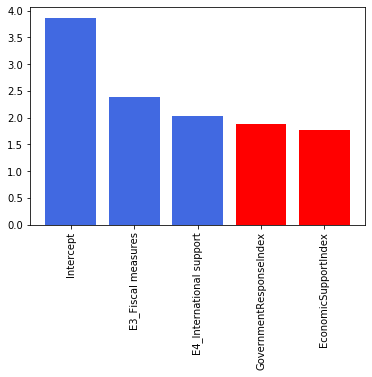

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept     3.870431
88           Country_Italy     2.395273
84            Country_Iran     2.026750
116    Country_New Zealand    -1.881869
166        Country_Vietnam    -1.768386
81         Country_Iceland    -1.582096
83       Country_Indonesia     1.509286
82           Country_India    -1.445238
144          Country_Spain     1.369132
203  E1_Income support_2.0     1.354695

Bias: 1.09
Mean squared error: 2.23
RSS: 3393.29
Variance score: 0.80

R2 score: 0.71

                           Feature  Coefficient
7           ContainmentHealthIndex  -973.760035
5                  StringencyIndex   904.162670
212          H2_Testing policy_3.0   136.372561
209          H2_Testing policy_0.0  -135.854217
213         H3_Contact tracing_0.0  -135.512430
..                             ...          ...
4        H5_Investment in vaccines 

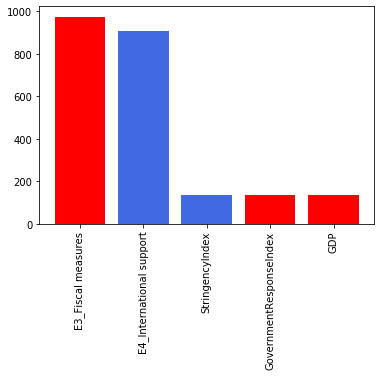

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex  -973.760035
5            StringencyIndex   904.162670
212    H2_Testing policy_3.0   136.372561
209    H2_Testing policy_0.0  -135.854217
213   H3_Contact tracing_0.0  -135.512430
215   H3_Contact tracing_2.0   135.400368
0                  Intercept    93.980836
6    GovernmentResponseIndex   -71.059344
210    H2_Testing policy_1.0   -45.740852
211    H2_Testing policy_2.0    45.222506

Bias: 1.08
Mean squared error: 2.19
RSS: 3325.70
Variance score: 0.81

R2 score: 0.71

Cutting dataframe on date: 2020-05-26
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     1.152515
8             EconomicSupportIndex     0.043728
19   Days Elapsed Since First Case     0.035881
150                 Country_Sweden     0.000000
139         

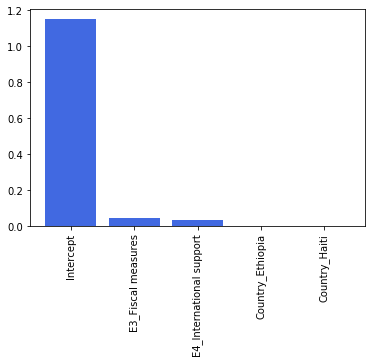

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.152515
8             EconomicSupportIndex     0.043728
19   Days Elapsed Since First Case     0.035881
150                 Country_Sweden     0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa     0.000000

Bias: 2.52
Mean squared error: 5.62
RSS: 11593.63
Variance score: 0.50

R2 score: 0.23

                                        Feature  Coefficient
0                                     Intercept     4.046399
89                                Country_Italy     2.354261
85                                 Country_Iran     2.044894
118                         Country_Ne

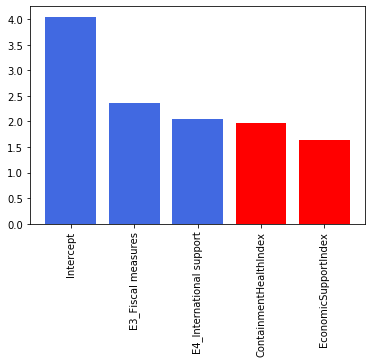

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept     4.046399
89           Country_Italy     2.354261
85            Country_Iran     2.044894
118    Country_New Zealand    -1.977476
168        Country_Vietnam    -1.632295
83           Country_India    -1.550863
82         Country_Iceland    -1.449094
146          Country_Spain     1.369424
84       Country_Indonesia     1.329526
205  E1_Income support_2.0     1.309628

Bias: 1.02
Mean squared error: 2.55
RSS: 5266.29
Variance score: 0.80

R2 score: 0.65

                                      Feature   Coefficient
0                                   Intercept  6.053844e+09
195  C7_Restrictions on internal movement_0.0 -1.714541e+09
197  C7_Restrictions on internal movement_2.0 -1.714541e+09
196  C7_Restrictions on internal movement_1.0 -1.714541e+09
172                     C1_School closing_0.0 -1.262843e+09
..         

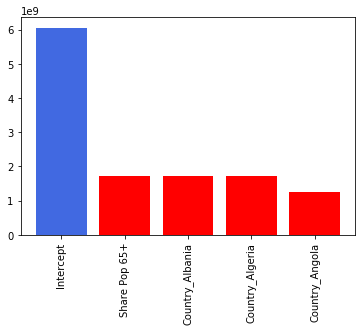

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                      Feature   Coefficient
0                                   Intercept  6.053844e+09
195  C7_Restrictions on internal movement_0.0 -1.714541e+09
197  C7_Restrictions on internal movement_2.0 -1.714541e+09
196  C7_Restrictions on internal movement_1.0 -1.714541e+09
172                     C1_School closing_0.0 -1.262843e+09
175                     C1_School closing_3.0 -1.262843e+09
174                     C1_School closing_2.0 -1.262843e+09
173                     C1_School closing_1.0 -1.262843e+09
203                     E1_Income support_0.0 -9.550235e+08
204                     E1_Income support_1.0 -9.550235e+08

Bias: 1.02
Mean squared error: 2.53
RSS: 5210.93
Variance score: 0.80

R2 score: 0.66

Cutting dataframe on date: 2020-05-19
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0     

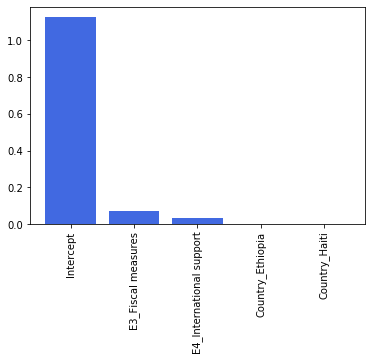

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.127523
8             EconomicSupportIndex     0.073393
19   Days Elapsed Since First Case     0.033941
150                 Country_Sweden     0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa     0.000000

Bias: 2.32
Mean squared error: 5.70
RSS: 12017.29
Variance score: 0.48

R2 score: 0.21

                           Feature  Coefficient
0                        Intercept     4.262495
89                   Country_Italy     2.249722
85                    Country_Iran     2.068066
118            Country_New Zealand    -1.887505
168                Country_Vietnam    -1.5

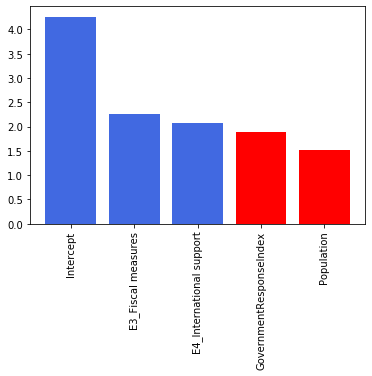

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.262495
89                      Country_Italy     2.249722
85                       Country_Iran     2.068066
118               Country_New Zealand    -1.887505
168                   Country_Vietnam    -1.525282
83                      Country_India    -1.516641
205             E1_Income support_2.0     1.338655
164  Country_United States of America    -1.276175
82                    Country_Iceland    -1.274436
203             E1_Income support_0.0    -1.259209

Bias: 0.94
Mean squared error: 2.79
RSS: 5892.06
Variance score: 0.79

R2 score: 0.61

                      Feature  Coefficient
5             StringencyIndex   997.326797
7      ContainmentHealthIndex  -873.618435
6     GovernmentResponseIndex  -295.305328
214     H2_Testing policy_3.0   152.635827
211     H2_Testing policy_0.0  -152

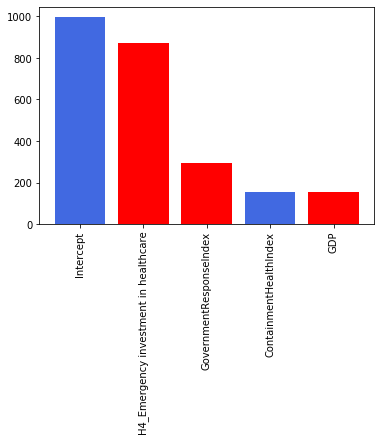

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
5            StringencyIndex   997.326797
7     ContainmentHealthIndex  -873.618435
6    GovernmentResponseIndex  -295.305328
214    H2_Testing policy_3.0   152.635827
211    H2_Testing policy_0.0  -152.142705
215   H3_Contact tracing_0.0  -151.795862
217   H3_Contact tracing_2.0   151.664280
0                  Intercept   125.257259
212    H2_Testing policy_1.0   -51.138011
213    H2_Testing policy_2.0    50.644889

Bias: 0.93
Mean squared error: 2.79
RSS: 5884.65
Variance score: 0.79

R2 score: 0.61

Cutting dataframe on date: 2020-05-12
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     1.081153
8             EconomicSupportIndex     0.089875
19   Days Elapsed Since First Case     0.031549
150                 Country_Sweden     0.000000
139         

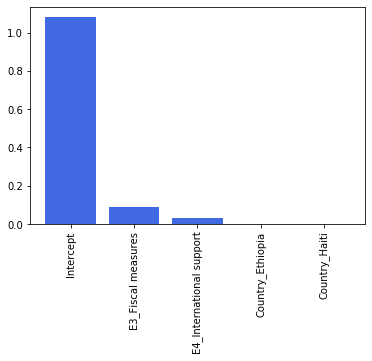

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.081153
8             EconomicSupportIndex     0.089875
19   Days Elapsed Since First Case     0.031549
150                 Country_Sweden     0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000

Bias: 2.10
Mean squared error: 5.89
RSS: 12369.60
Variance score: 0.46

R2 score: 0.18

                       Feature  Coefficient
0                    Intercept     4.409666
89               Country_Italy     2.107556
85                Country_Iran     2.056699
118        Country_New Zealand    -1.824733
83               Country_India    -1.491530
..                

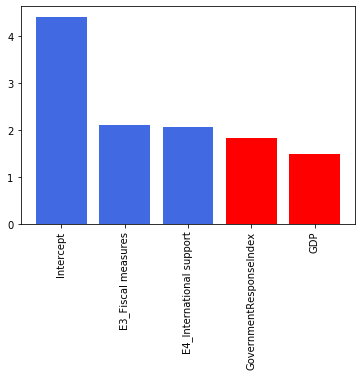

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.409666
89                      Country_Italy     2.107556
85                       Country_Iran     2.056699
118               Country_New Zealand    -1.824733
83                      Country_India    -1.491530
168                   Country_Vietnam    -1.412670
205             E1_Income support_2.0     1.368800
203             E1_Income support_0.0    -1.272680
164  Country_United States of America    -1.248613
146                     Country_Spain     1.177866

Bias: 0.85
Mean squared error: 2.91
RSS: 6114.24
Variance score: 0.78

R2 score: 0.59

                                   Feature   Coefficient
0                                Intercept -6.215615e+09
182            C3_Cancel public events_2.0  4.056790e+09
181            C3_Cancel public events_1.0  4.056790e+09
180            C3_Canc

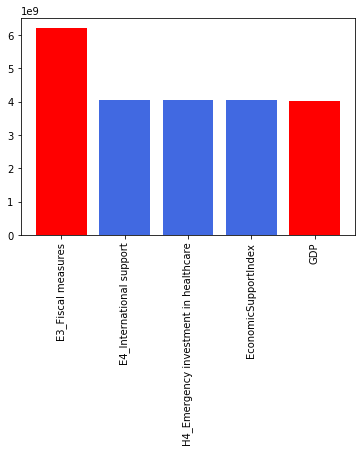

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                              Feature   Coefficient
0                           Intercept -6.215615e+09
182       C3_Cancel public events_2.0  4.056790e+09
181       C3_Cancel public events_1.0  4.056790e+09
180       C3_Cancel public events_0.0  4.056790e+09
191  C6_Stay at home requirements_0.0 -4.036081e+09
192  C6_Stay at home requirements_1.0 -4.036081e+09
194  C6_Stay at home requirements_3.0 -4.036081e+09
193  C6_Stay at home requirements_2.0 -4.036081e+09
205             E1_Income support_2.0  3.399106e+09
204             E1_Income support_1.0  3.399106e+09

Bias: 0.84
Mean squared error: 2.91
RSS: 6107.05
Variance score: 0.78

R2 score: 0.59

Cutting dataframe on date: 2020-05-05
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     0.980692
8             EconomicSupportIndex     0.07879

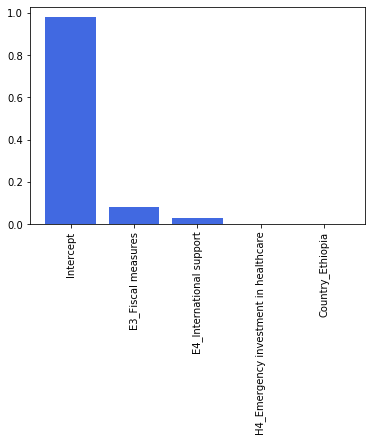

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     0.980692
8             EconomicSupportIndex     0.078794
19   Days Elapsed Since First Case     0.028379
18                       Day Count     0.000438
150                 Country_Sweden     0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000

Bias: 1.87
Mean squared error: 6.26
RSS: 13151.02
Variance score: 0.42

R2 score: 0.11

                      Feature  Coefficient
0                   Intercept     4.509162
85               Country_Iran     2.030966
89              Country_Italy     1.952850
118       Country_New Zealand    -1.761181
83              Country_India    -1.483773
..                      

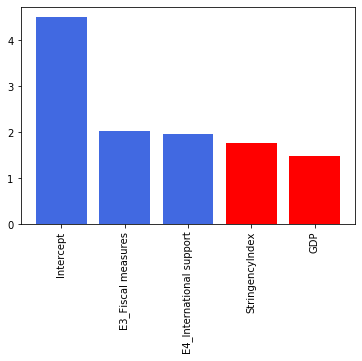

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.509162
85                       Country_Iran     2.030966
89                      Country_Italy     1.952850
118               Country_New Zealand    -1.761181
83                      Country_India    -1.483773
205             E1_Income support_2.0     1.384318
168                   Country_Vietnam    -1.290732
203             E1_Income support_0.0    -1.247231
164  Country_United States of America    -1.223175
146                     Country_Spain     1.081807

Bias: 0.74
Mean squared error: 2.99
RSS: 6289.80
Variance score: 0.77

R2 score: 0.57

                       Feature  Coefficient
5              StringencyIndex   750.558671
7       ContainmentHealthIndex  -602.118905
6      GovernmentResponseIndex  -280.781827
214      H2_Testing policy_3.0   121.623925
211      H2_Testing policy_0.0

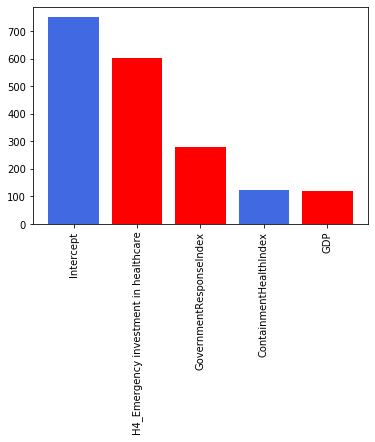

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
5            StringencyIndex   750.558671
7     ContainmentHealthIndex  -602.118905
6    GovernmentResponseIndex  -280.781827
214    H2_Testing policy_3.0   121.623925
211    H2_Testing policy_0.0  -121.184429
215   H3_Contact tracing_0.0  -120.849583
217   H3_Contact tracing_2.0   120.737917
0                  Intercept   118.794344
212    H2_Testing policy_1.0   -40.772034
213    H2_Testing policy_2.0    40.332539

Bias: 0.74
Mean squared error: 2.96
RSS: 6228.86
Variance score: 0.77

R2 score: 0.58

Cutting dataframe on date: 2020-04-28
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     0.869492
8             EconomicSupportIndex     0.036654
19   Days Elapsed Since First Case     0.025020
18                       Day Count     0.000602
150         

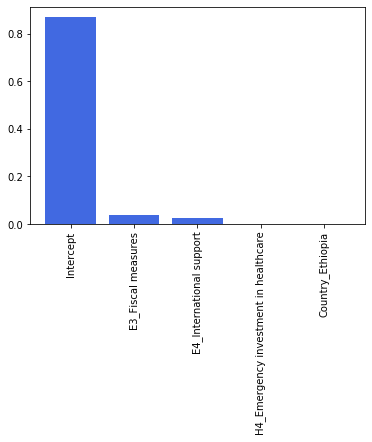

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     0.869492
8             EconomicSupportIndex     0.036654
19   Days Elapsed Since First Case     0.025020
18                       Day Count     0.000602
150                 Country_Sweden    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000

Bias: 1.63
Mean squared error: 6.84
RSS: 14449.82
Variance score: 0.36

R2 score: -0.01

                 Feature  Coefficient
0              Intercept     4.873656
85          Country_Iran     1.965429
89         Country_Italy     1.770242
118  Country_New Zealand    -1.641915
83         Country_India    -1.451293
..                   ...          ...
72        Count

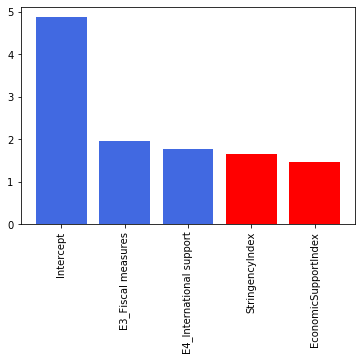

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.873656
85                       Country_Iran     1.965429
89                      Country_Italy     1.770242
118               Country_New Zealand    -1.641915
83                      Country_India    -1.451293
205             E1_Income support_2.0     1.375764
203             E1_Income support_0.0    -1.191680
164  Country_United States of America    -1.183752
50                      Country_China     1.159775
168                   Country_Vietnam    -1.117899

Bias: 0.62
Mean squared error: 3.12
RSS: 6594.66
Variance score: 0.76

R2 score: 0.54

                                   Feature   Coefficient
0                                Intercept  3.787872e+10
164       Country_United States of America  1.504383e+10
206            E2_Debt/contract relief_0.0 -1.485709e+10
207            E2_Debt

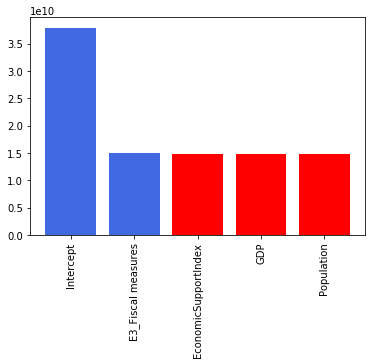

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                 Feature   Coefficient
0                              Intercept  3.787872e+10
164     Country_United States of America  1.504383e+10
206          E2_Debt/contract relief_0.0 -1.485709e+10
207          E2_Debt/contract relief_1.0 -1.485709e+10
208          E2_Debt/contract relief_2.0 -1.485709e+10
216               H3_Contact tracing_0.0 -1.195050e+10
217               H3_Contact tracing_1.0 -1.195050e+10
218               H3_Contact tracing_2.0 -1.195050e+10
211  H1_Public information campaigns_2.0  1.103980e+10
210  H1_Public information campaigns_1.0  1.103980e+10

Bias: 0.62
Mean squared error: 3.09
RSS: 6534.30
Variance score: 0.76

R2 score: 0.54

Cutting dataframe on date: 2020-04-21
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     0.764716
19   Days Ela

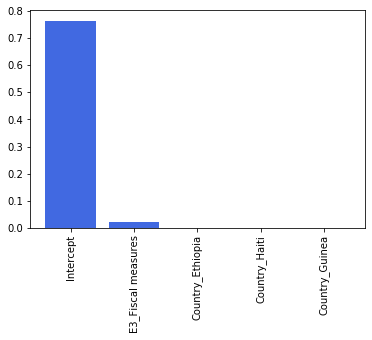

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     0.764716
19   Days Elapsed Since First Case     0.021114
137                Country_Senegal    -0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000
145            Country_South Korea     0.000000

Bias: 1.33
Mean squared error: 7.52
RSS: 15920.87
Variance score: 0.29

R2 score: -0.19

                              Feature  Coefficient
0                           Intercept     4.703599
85                       Country_Iran     1.867592
89                      Country_Italy     1.560273
83                      Country_India    -1.387733
118               Country_

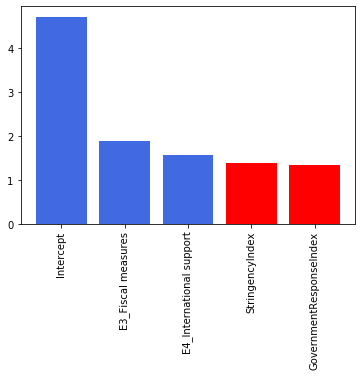

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.703599
85                       Country_Iran     1.867592
89                      Country_Italy     1.560273
83                      Country_India    -1.387733
118               Country_New Zealand    -1.330103
205             E1_Income support_2.0     1.294361
50                      Country_China     1.237338
164  Country_United States of America    -1.122396
203             E1_Income support_0.0    -1.043147
168                   Country_Vietnam    -0.968755

Bias: 0.48
Mean squared error: 3.19
RSS: 6746.58
Variance score: 0.74

R2 score: 0.50

                                   Feature   Coefficient
164       Country_United States of America  3.285722e+09
0                                Intercept -2.632506e+09
208            E2_Debt/contract relief_2.0  2.519091e+09
207            E2_Debt

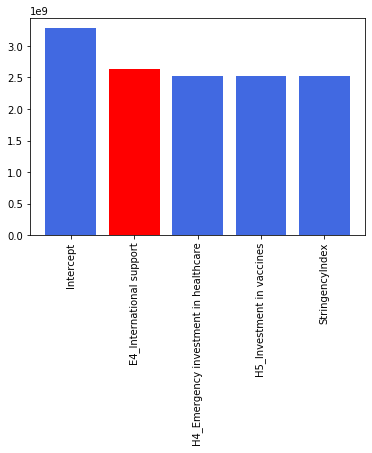

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                 Feature   Coefficient
164     Country_United States of America  3.285722e+09
0                              Intercept -2.632506e+09
208          E2_Debt/contract relief_2.0  2.519091e+09
207          E2_Debt/contract relief_1.0  2.519091e+09
206          E2_Debt/contract relief_0.0  2.519091e+09
50                         Country_China  2.044152e+09
151                  Country_Switzerland -1.875376e+09
83                         Country_India -1.825783e+09
103                   Country_Luxembourg -1.479690e+09
211  H1_Public information campaigns_2.0  1.362125e+09

Bias: 0.48
Mean squared error: 3.17
RSS: 6721.29
Variance score: 0.74

R2 score: 0.50



In [13]:
weeks_for_cv = [0,1,2,3,4,5,6]
n_weeks_prediction = 2
results = {}
for i in weeks_for_cv:
    shorter_df = pipeline.cut_df_on_weeks(df, i)
    df_train, df_test = pipeline.split_and_scale_on_last_weeks(shorter_df, n_weeks_prediction)
    pipeline.sanity_check(df_train, df_test)
    X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
    X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
    dct = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)
    results['Until week: ' +str(i)] = dct

In [14]:
# summarizing time seried nested Cross Validation: 

metrics_mse = pd.DataFrame(columns=['Lasso','Ridge','Linear Regression'])
for i, mkey in enumerate(results):
    for key in results[mkey]:
        metrics_mse.loc[i,key] = results[mkey][key][2]
metrics_mse

,Lasso,Ridge,Linear Regression
0,8753.19,3393.29,3325.7
1,11593.6,5266.29,5210.93
2,12017.3,5892.06,5884.65
3,12369.6,6114.24,6107.05
4,13151,6289.8,6228.86
5,14449.8,6594.66,6534.3
6,15920.9,6746.58,6721.29


In [8]:
# finding averages across all folds

print("Lasso 7 fold avg:", metrics_r2['Lasso'].mean())
print("Ridge 7 fold avg:", metrics_r2['Ridge'].mean())
print("Linear Regression 7 fold avg:", metrics_r2['Linear Regression'].mean() )

Lasso 7 fold avg: 0.40165142100778917
Ridge 7 fold avg: 0.6866950469493348
Linear Regression 7 fold avg: 0.6884065847075777


### Conclusion: 

- in this Time Series Nested Cross Validation test, the Linear Regression Model performs the best.

## Decison Tree Regressor  and Random Forest 

- Below running Decision tree Regressor on Confirmed Cases and on Deaths 

In [3]:
## setting up Train and test dfs

## df for confirmed cases 
filepath = '../data/covid_df_protocol_3.pkl'
df = pd.read_pickle(filepath)
df['log_cases'] = df['Confirmed Cases']
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df, 2)
pipeline.sanity_check(df_train, df_test)
X_train, y_train_cases = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test_cases = pipeline.divide_target_and_features(df_test, 'log_cases')


## df for deaths
df = pd.read_pickle(filepath)
df['log_cases'] = df['Deaths']
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df, 2)
pipeline.sanity_check(df_train, df_test)
X_train, y_train_deaths = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test_deaths = pipeline.divide_target_and_features(df_test, 'log_cases')

Success: Features match
Success: No NAs remain
Success: Features match
Success: No NAs remain


In [4]:
## fitting models

# on Confirmed Cases
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train_cases)
y_pred_cases = dtr.predict(X_test)
pipeline.metrics(y_pred_cases, y_test_cases, X_train, y_train_cases, dtr)

Bias: 0.00
Mean squared error: 664035657.37
RSS: 1009998234865.00
Variance score: 1.00

R2 score: 0.98



(0.0, 664035657.3734385, 1009998234865.0, 1.0, 0.9772276474985314)

In [5]:
# making prediction and saving it to a pickle file
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_cases, y_test_cases)
predictions.to_pickle("../predictions/cases_dtr.pkl")

In [6]:
# Decision Tree Regresson  on Deaths
dtr.fit(X_train, y_train_deaths)
y_pred_deaths = dtr.predict(X_test)
pipeline.metrics(y_pred_deaths, y_test_deaths, X_train, y_train_deaths, dtr)

Bias: 0.00
Mean squared error: 22433439.07
RSS: 34121260831.00
Variance score: 1.00

R2 score: 0.82



(0.0, 22433439.073635764, 34121260831.0, 1.0, 0.8183705429170611)

In [7]:
# making prediction and saving it to a pickle file
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths, y_test_deaths)
predictions.to_pickle("../predictions/deaths_dtr.pkl")

## Random Forest Regression

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Confirmed Cases
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train_cases)

RandomForestClassifier(random_state=0)

In [26]:
# dont run this, takes really long time, 
# import pickle
# pickle.dump(rf, open("../trained_classifiers/rf_cases.pkl", 'wb'))

In [10]:
y_pred_cases = rf.predict(X_test)
pipeline.metrics(y_pred_cases, y_test_cases, X_train, y_train_cases, rf)

Bias: 0.00
Mean squared error: 493960547.33
RSS: 751313992493.00
Variance score: 1.00

R2 score: 0.98



(0.0, 493960547.3326759, 751313992493.0, 1.0, 0.9830601812104917)

In [11]:
# making prediction and saving it to a pickle file
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_cases, y_test_cases)
predictions.to_pickle("../predictions/cases_rf.pkl")

In [12]:
# for Deaths
rf.fit(X_train, y_train_deaths)
y_pred_deaths = rf.predict(X_test)
pipeline.metrics(y_pred_deaths, y_test_deaths, X_train, y_train_deaths, rf)

Bias: 0.00
Mean squared error: 1213721.47
RSS: 1846070355.00
Variance score: 1.00

R2 score: 0.99



(0.0, 1213721.469428008, 1846070355.0, 1.0, 0.9901732600686628)

In [13]:
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths, y_test_deaths)
predictions.to_pickle("../predictions/deaths_rf.pkl")

## <FIXME: WORK FROM HERE>

In [11]:
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)

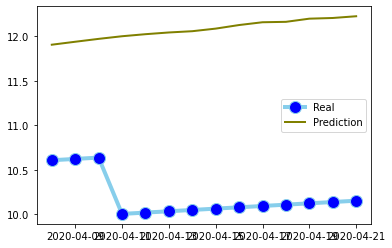

In [12]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'Spain')

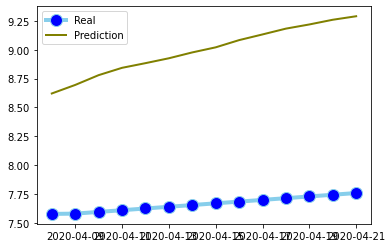

In [13]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'Chile')

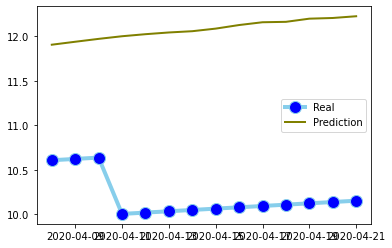

In [14]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'Spain')

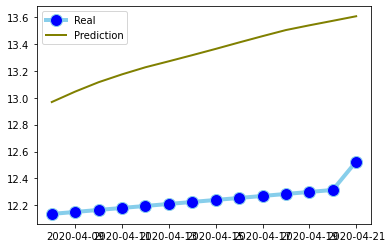

In [15]:
pipeline.plot_real_vs_prediction(X_test, y_pred, y_test, 'United States of America')

In [20]:
predictions = pipeline.predictions_every_country(X_test.columns[19:171], X_test, y_pred, y_test)

## We save the predictions and model in a pickle 

In [25]:
import pickle
predictions.to_pickle("../predictions/lreg_log_cases.pkl")
pickle.dump(lreg, open("../trained_classifiers/lreg_log_cases.pkl", 'wb'))

## We do the same with number of deaths as target

                           Feature  Coefficient
0                        Intercept     2.227549
6          GovernmentResponseIndex     0.219709
8             EconomicSupportIndex     0.209258
5                  StringencyIndex     0.105772
19   Days Elapsed Since First Case     0.048866
..                             ...          ...
79                   Country_Haiti    -0.000000
80                Country_Honduras    -0.000000
81                 Country_Hungary    -0.000000
82                 Country_Iceland     0.000000
218         H3_Contact tracing_2.0     0.000000

[219 rows x 2 columns]


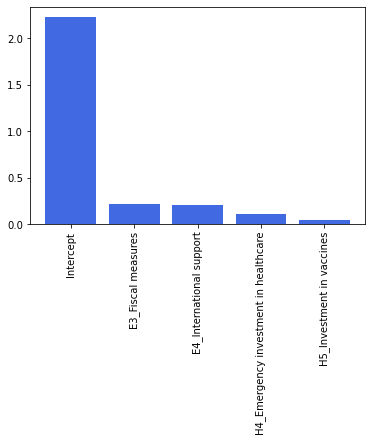

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     2.227549
6          GovernmentResponseIndex     0.219709
8             EconomicSupportIndex     0.209258
5                  StringencyIndex     0.105772
19   Days Elapsed Since First Case     0.048866
18                       Day Count     0.000103
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
141              Country_Singapore     0.000000
144           Country_South Africa     0.000000

Bias: 2.27
Mean squared error: 5.11
RSS: 10827.80
Variance score: 0.67

R2 score: 0.32

                      Feature  Coefficient
0                   Intercept     9.870979
205     E1_Income support_2.0     2.090254
85               Country_Iran     1.882329
203     E1_Income support_0.0    -1.708294
112          Country_Mongolia    -1.605098
..                      

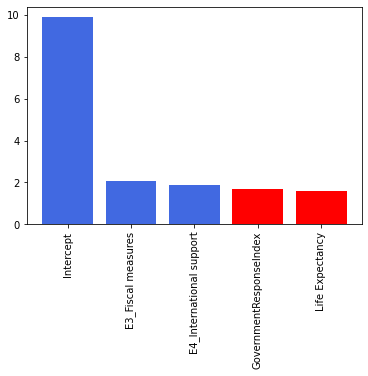

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept     9.870979
205        E1_Income support_2.0     2.090254
85                  Country_Iran     1.882329
203        E1_Income support_0.0    -1.708294
112             Country_Mongolia    -1.605098
206  E2_Debt/contract relief_0.0    -1.553873
208  E2_Debt/contract relief_2.0     1.492464
83                 Country_India    -1.345067
172        C1_School closing_0.0    -1.308201
116                Country_Nepal    -1.256788

Bias: 0.93
Mean squared error: 2.55
RSS: 5390.44
Variance score: 0.87

R2 score: 0.66

                                   Feature   Coefficient
0                                Intercept -1.267678e+10
99                         Country_Lesotho -5.347512e+09
67                        Country_Eswatini -4.954833e+09
164       Country_United States of America -4.535725e+09
190          C5_Clos

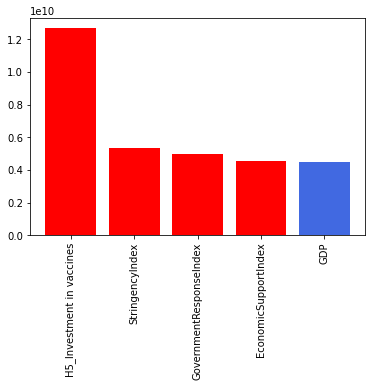

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                      Feature   Coefficient
0                                   Intercept -1.267678e+10
99                            Country_Lesotho -5.347512e+09
67                           Country_Eswatini -4.954833e+09
164          Country_United States of America -4.535725e+09
190             C5_Close public transport_2.0  4.521832e+09
189             C5_Close public transport_1.0  4.521832e+09
188             C5_Close public transport_0.0  4.521832e+09
144                      Country_South Africa -3.835699e+09
104                        Country_Madagascar  3.748124e+09
197  C7_Restrictions on internal movement_2.0  3.550641e+09

Bias: 0.93
Mean squared error: 2.55
RSS: 5390.49
Variance score: 0.87

R2 score: 0.66



In [26]:
df['log_cases'] = np.log(df['Deaths'] + 1)
# Getting Features and outcome variables
X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
results_dict = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)

In [27]:
# comparing the metrics for all three models
rs = pd.DataFrame(results_dict) 
rs['metrics']= ['Bias','MSE','RSS','Variance','R2']
rs.set_index('metrics')

,Lasso,Ridge,Linear Regression
metrics,,,
Bias,2.271476,0.925891,0.925528
MSE,5.112277,2.545062,2.545083
RSS,10827.803103,5390.442201,5390.485155
Variance,0.674766,0.867429,0.867481
R2,0.324463,0.663695,0.663692


## Cross validation

Cutting dataframe on date: 2020-06-02
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     1.169714
19   Days Elapsed Since First Case     0.037368
8             EconomicSupportIndex     0.014982
18                       Day Count    -0.000150
149            Country_Switzerland     0.000000
..                             ...          ...
77                  Country_Guinea    -0.000000
78                   Country_Haiti    -0.000000
79                Country_Honduras     0.000000
80                 Country_Hungary     0.000000
215         H3_Contact tracing_2.0    -0.000000

[216 rows x 2 columns]


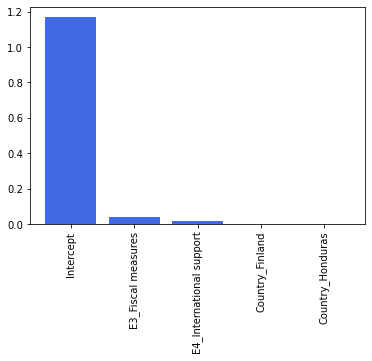

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.169714
19   Days Elapsed Since First Case     0.037368
8             EconomicSupportIndex     0.014982
18                       Day Count    -0.000150
149            Country_Switzerland     0.000000
139              Country_Singapore    -0.000000
140        Country_Slovak Republic    -0.000000
141               Country_Slovenia     0.000000
142           Country_South Africa     0.000000
143            Country_South Korea     0.000000

Bias: 2.70
Mean squared error: 5.75
RSS: 8753.19
Variance score: 0.51

R2 score: 0.24

                      Feature  Coefficient
0                   Intercept     3.870431
88              Country_Italy     2.395273
84               Country_Iran     2.026750
116       Country_New Zealand    -1.881869
166           Country_Vietnam    -1.768386
..                       

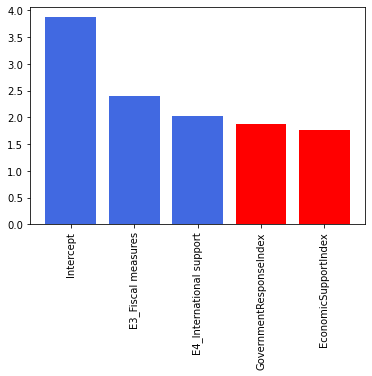

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept     3.870431
88           Country_Italy     2.395273
84            Country_Iran     2.026750
116    Country_New Zealand    -1.881869
166        Country_Vietnam    -1.768386
81         Country_Iceland    -1.582096
83       Country_Indonesia     1.509286
82           Country_India    -1.445238
144          Country_Spain     1.369132
203  E1_Income support_2.0     1.354695

Bias: 1.09
Mean squared error: 2.23
RSS: 3393.29
Variance score: 0.80

R2 score: 0.71

                           Feature  Coefficient
7           ContainmentHealthIndex  -973.760035
5                  StringencyIndex   904.162670
212          H2_Testing policy_3.0   136.372561
209          H2_Testing policy_0.0  -135.854216
213         H3_Contact tracing_0.0  -135.512430
..                             ...          ...
4        H5_Investment in vaccines 

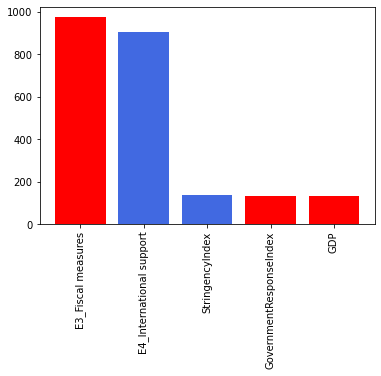

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex  -973.760035
5            StringencyIndex   904.162670
212    H2_Testing policy_3.0   136.372561
209    H2_Testing policy_0.0  -135.854216
213   H3_Contact tracing_0.0  -135.512430
215   H3_Contact tracing_2.0   135.400368
0                  Intercept    93.980837
6    GovernmentResponseIndex   -71.059344
210    H2_Testing policy_1.0   -45.740851
211    H2_Testing policy_2.0    45.222506

Bias: 1.08
Mean squared error: 2.19
RSS: 3325.70
Variance score: 0.81

R2 score: 0.71

Cutting dataframe on date: 2020-05-26
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     1.152515
8             EconomicSupportIndex     0.043728
19   Days Elapsed Since First Case     0.035881
150                 Country_Sweden     0.000000
139         

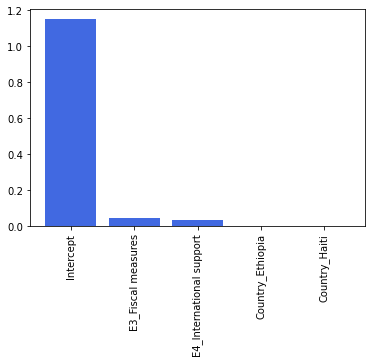

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.152515
8             EconomicSupportIndex     0.043728
19   Days Elapsed Since First Case     0.035881
150                 Country_Sweden     0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa     0.000000

Bias: 2.52
Mean squared error: 5.62
RSS: 11593.63
Variance score: 0.50

R2 score: 0.23

                                        Feature  Coefficient
0                                     Intercept     4.046399
89                                Country_Italy     2.354261
85                                 Country_Iran     2.044894
118                         Country_Ne

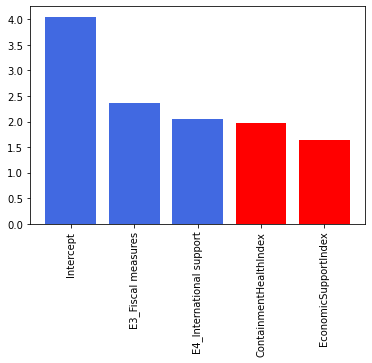

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept     4.046399
89           Country_Italy     2.354261
85            Country_Iran     2.044894
118    Country_New Zealand    -1.977476
168        Country_Vietnam    -1.632295
83           Country_India    -1.550863
82         Country_Iceland    -1.449094
146          Country_Spain     1.369424
84       Country_Indonesia     1.329526
205  E1_Income support_2.0     1.309628

Bias: 1.02
Mean squared error: 2.55
RSS: 5266.29
Variance score: 0.80

R2 score: 0.65

                                   Feature   Coefficient
0                                Intercept -1.320544e+10
164       Country_United States of America -6.835277e+09
50                           Country_China -5.109052e+09
217                 H3_Contact tracing_2.0  4.588288e+09
216                 H3_Contact tracing_1.0  4.588287e+09
..                           

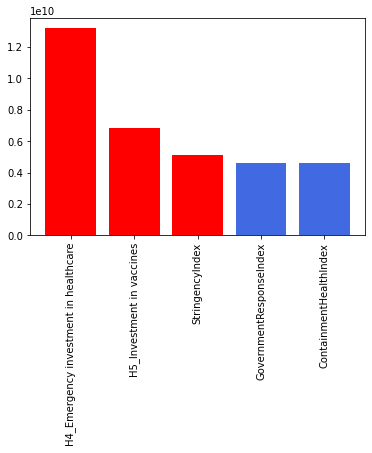

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                              Feature   Coefficient
0                           Intercept -1.320544e+10
164  Country_United States of America -6.835277e+09
50                      Country_China -5.109052e+09
217            H3_Contact tracing_2.0  4.588288e+09
216            H3_Contact tracing_1.0  4.588287e+09
215            H3_Contact tracing_0.0  4.588287e+09
193  C6_Stay at home requirements_2.0  3.935883e+09
194  C6_Stay at home requirements_3.0  3.935883e+09
192  C6_Stay at home requirements_1.0  3.935883e+09
191  C6_Stay at home requirements_0.0  3.935883e+09

Bias: 1.02
Mean squared error: 2.53
RSS: 5211.03
Variance score: 0.80

R2 score: 0.66

Cutting dataframe on date: 2020-05-19
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     1.127523
8             EconomicSupportIndex     0.07339

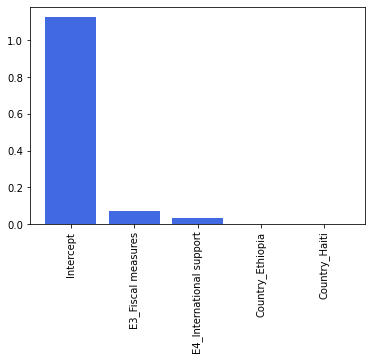

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.127523
8             EconomicSupportIndex     0.073393
19   Days Elapsed Since First Case     0.033941
150                 Country_Sweden     0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa     0.000000

Bias: 2.32
Mean squared error: 5.70
RSS: 12017.29
Variance score: 0.48

R2 score: 0.21

                           Feature  Coefficient
0                        Intercept     4.262495
89                   Country_Italy     2.249722
85                    Country_Iran     2.068066
118            Country_New Zealand    -1.887505
168                Country_Vietnam    -1.5

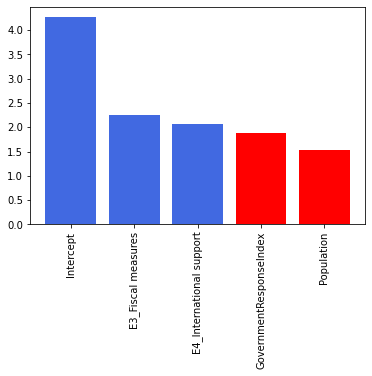

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.262495
89                      Country_Italy     2.249722
85                       Country_Iran     2.068066
118               Country_New Zealand    -1.887505
168                   Country_Vietnam    -1.525282
83                      Country_India    -1.516641
205             E1_Income support_2.0     1.338655
164  Country_United States of America    -1.276175
82                    Country_Iceland    -1.274436
203             E1_Income support_0.0    -1.259209

Bias: 0.94
Mean squared error: 2.79
RSS: 5892.06
Variance score: 0.79

R2 score: 0.61

                      Feature  Coefficient
5             StringencyIndex   997.326797
7      ContainmentHealthIndex  -873.618435
6     GovernmentResponseIndex  -295.305328
214     H2_Testing policy_3.0   152.635827
211     H2_Testing policy_0.0  -152

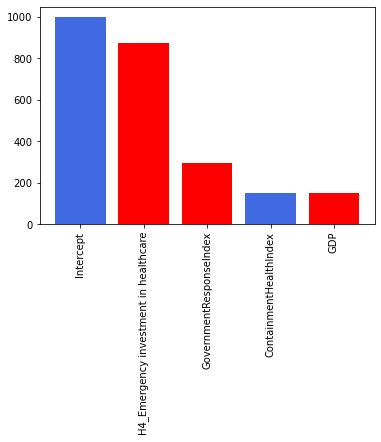

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
5            StringencyIndex   997.326797
7     ContainmentHealthIndex  -873.618435
6    GovernmentResponseIndex  -295.305328
214    H2_Testing policy_3.0   152.635827
211    H2_Testing policy_0.0  -152.142705
215   H3_Contact tracing_0.0  -151.795862
217   H3_Contact tracing_2.0   151.664280
0                  Intercept   125.257258
212    H2_Testing policy_1.0   -51.138011
213    H2_Testing policy_2.0    50.644889

Bias: 0.93
Mean squared error: 2.79
RSS: 5884.65
Variance score: 0.79

R2 score: 0.61

Cutting dataframe on date: 2020-05-12
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     1.081153
8             EconomicSupportIndex     0.089875
19   Days Elapsed Since First Case     0.031549
150                 Country_Sweden     0.000000
139         

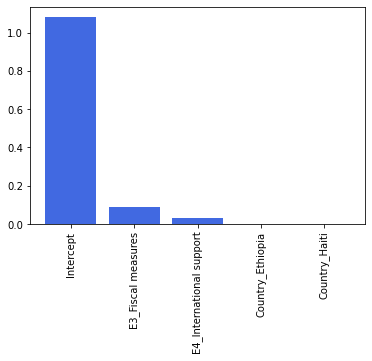

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     1.081153
8             EconomicSupportIndex     0.089875
19   Days Elapsed Since First Case     0.031549
150                 Country_Sweden     0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000

Bias: 2.10
Mean squared error: 5.89
RSS: 12369.60
Variance score: 0.46

R2 score: 0.18

                       Feature  Coefficient
0                    Intercept     4.409666
89               Country_Italy     2.107556
85                Country_Iran     2.056699
118        Country_New Zealand    -1.824733
83               Country_India    -1.491530
..                

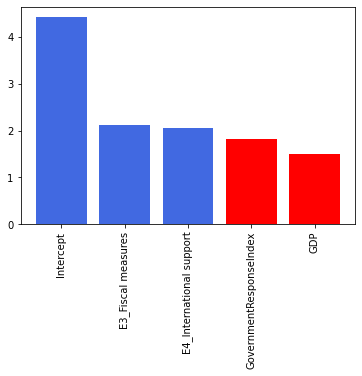

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.409666
89                      Country_Italy     2.107556
85                       Country_Iran     2.056699
118               Country_New Zealand    -1.824733
83                      Country_India    -1.491530
168                   Country_Vietnam    -1.412670
205             E1_Income support_2.0     1.368800
203             E1_Income support_0.0    -1.272680
164  Country_United States of America    -1.248613
146                     Country_Spain     1.177866

Bias: 0.85
Mean squared error: 2.91
RSS: 6114.24
Variance score: 0.78

R2 score: 0.59

                      Feature  Coefficient
5             StringencyIndex   980.420359
7      ContainmentHealthIndex  -807.202370
6     GovernmentResponseIndex  -345.133663
214     H2_Testing policy_3.0   153.248290
211     H2_Testing policy_0.0  -152

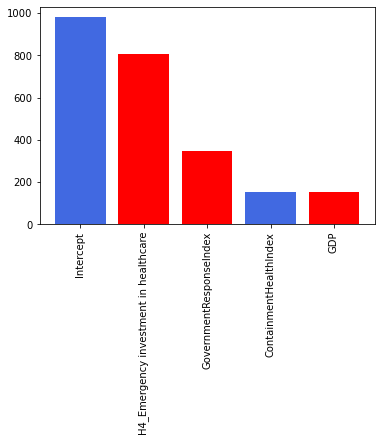

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
5            StringencyIndex   980.420359
7     ContainmentHealthIndex  -807.202370
6    GovernmentResponseIndex  -345.133663
214    H2_Testing policy_3.0   153.248290
211    H2_Testing policy_0.0  -152.794075
215   H3_Contact tracing_0.0  -152.466105
217   H3_Contact tracing_2.0   152.345122
0                  Intercept   136.948711
212    H2_Testing policy_1.0   -51.329916
213    H2_Testing policy_2.0    50.875702

Bias: 0.84
Mean squared error: 2.91
RSS: 6107.06
Variance score: 0.78

R2 score: 0.59

Cutting dataframe on date: 2020-05-05
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     0.980692
8             EconomicSupportIndex     0.078794
19   Days Elapsed Since First Case     0.028379
18                       Day Count     0.000438
150         

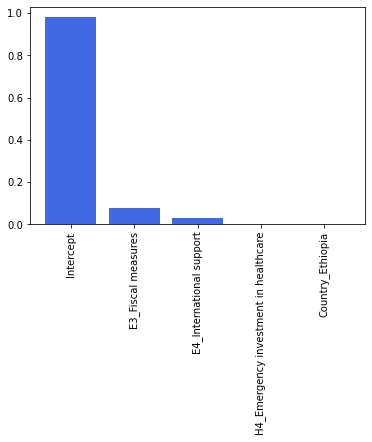

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     0.980692
8             EconomicSupportIndex     0.078794
19   Days Elapsed Since First Case     0.028379
18                       Day Count     0.000438
150                 Country_Sweden     0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000

Bias: 1.87
Mean squared error: 6.26
RSS: 13151.02
Variance score: 0.42

R2 score: 0.11

                      Feature  Coefficient
0                   Intercept     4.509162
85               Country_Iran     2.030966
89              Country_Italy     1.952850
118       Country_New Zealand    -1.761181
83              Country_India    -1.483773
..                      

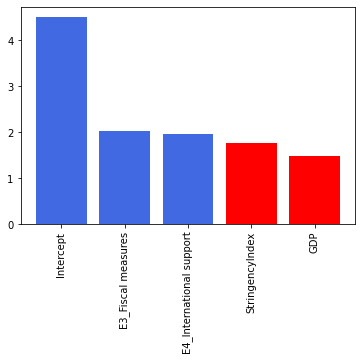

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.509162
85                       Country_Iran     2.030966
89                      Country_Italy     1.952850
118               Country_New Zealand    -1.761181
83                      Country_India    -1.483773
205             E1_Income support_2.0     1.384318
168                   Country_Vietnam    -1.290732
203             E1_Income support_0.0    -1.247231
164  Country_United States of America    -1.223175
146                     Country_Spain     1.081807

Bias: 0.74
Mean squared error: 2.99
RSS: 6289.80
Variance score: 0.77

R2 score: 0.57

                       Feature  Coefficient
5              StringencyIndex   750.558671
7       ContainmentHealthIndex  -602.118905
6      GovernmentResponseIndex  -280.781827
214      H2_Testing policy_3.0   121.623925
211      H2_Testing policy_0.0

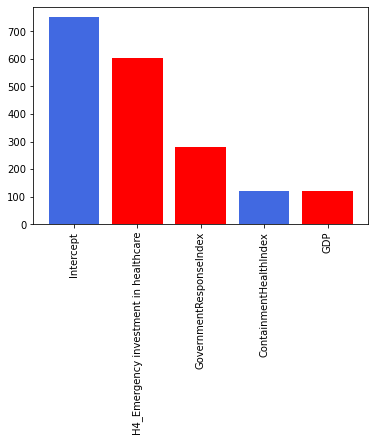

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
5            StringencyIndex   750.558671
7     ContainmentHealthIndex  -602.118905
6    GovernmentResponseIndex  -280.781827
214    H2_Testing policy_3.0   121.623925
211    H2_Testing policy_0.0  -121.184429
215   H3_Contact tracing_0.0  -120.849583
217   H3_Contact tracing_2.0   120.737917
0                  Intercept   118.794344
212    H2_Testing policy_1.0   -40.772034
213    H2_Testing policy_2.0    40.332539

Bias: 0.74
Mean squared error: 2.96
RSS: 6228.86
Variance score: 0.77

R2 score: 0.58

Cutting dataframe on date: 2020-04-28
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     0.869492
8             EconomicSupportIndex     0.036654
19   Days Elapsed Since First Case     0.025020
18                       Day Count     0.000602
150         

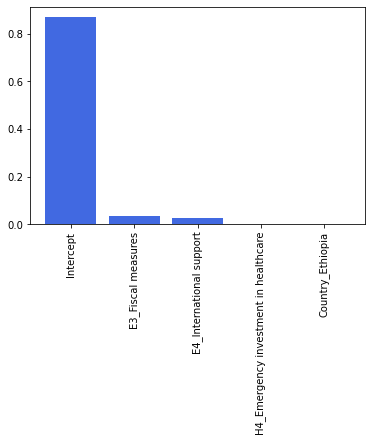

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     0.869492
8             EconomicSupportIndex     0.036654
19   Days Elapsed Since First Case     0.025020
18                       Day Count     0.000602
150                 Country_Sweden    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000

Bias: 1.63
Mean squared error: 6.84
RSS: 14449.82
Variance score: 0.36

R2 score: -0.01

                 Feature  Coefficient
0              Intercept     4.873656
85          Country_Iran     1.965429
89         Country_Italy     1.770242
118  Country_New Zealand    -1.641915
83         Country_India    -1.451293
..                   ...          ...
72        Count

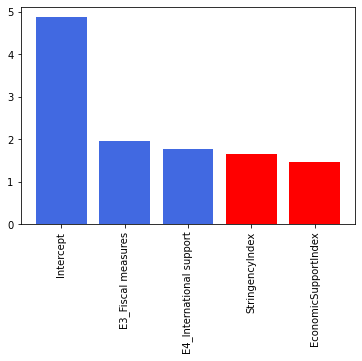

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.873656
85                       Country_Iran     1.965429
89                      Country_Italy     1.770242
118               Country_New Zealand    -1.641915
83                      Country_India    -1.451293
205             E1_Income support_2.0     1.375764
203             E1_Income support_0.0    -1.191680
164  Country_United States of America    -1.183752
50                      Country_China     1.159775
168                   Country_Vietnam    -1.117899

Bias: 0.62
Mean squared error: 3.12
RSS: 6594.66
Variance score: 0.76

R2 score: 0.54

                                   Feature   Coefficient
164       Country_United States of America  1.270216e+10
0                                Intercept -7.433097e+09
218                 H3_Contact tracing_2.0  6.129571e+09
217                 H3

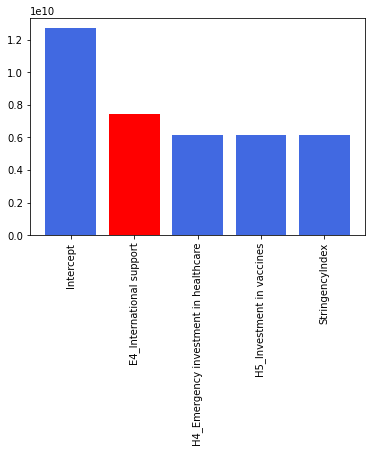

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                 Feature   Coefficient
164     Country_United States of America  1.270216e+10
0                              Intercept -7.433097e+09
218               H3_Contact tracing_2.0  6.129571e+09
217               H3_Contact tracing_1.0  6.129571e+09
216               H3_Contact tracing_0.0  6.129571e+09
50                         Country_China  5.016456e+09
209  H1_Public information campaigns_0.0 -3.559066e+09
210  H1_Public information campaigns_1.0 -3.559066e+09
211  H1_Public information campaigns_2.0 -3.559066e+09
215                H2_Testing policy_3.0  2.587774e+09

Bias: 0.62
Mean squared error: 3.09
RSS: 6534.40
Variance score: 0.76

R2 score: 0.54

Cutting dataframe on date: 2020-04-21
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept     0.764716
19   Days Ela

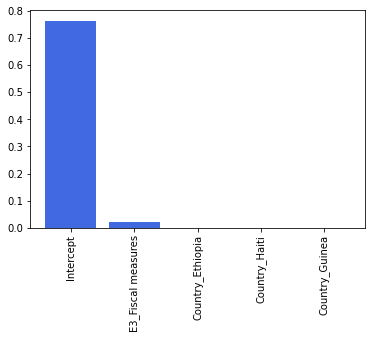

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept     0.764716
19   Days Elapsed Since First Case     0.021114
137                Country_Senegal    -0.000000
139             Country_Seychelles    -0.000000
140           Country_Sierra Leone     0.000000
141              Country_Singapore    -0.000000
142        Country_Slovak Republic    -0.000000
143               Country_Slovenia     0.000000
144           Country_South Africa    -0.000000
145            Country_South Korea     0.000000

Bias: 1.33
Mean squared error: 7.52
RSS: 15920.87
Variance score: 0.29

R2 score: -0.19

                              Feature  Coefficient
0                           Intercept     4.703599
85                       Country_Iran     1.867592
89                      Country_Italy     1.560273
83                      Country_India    -1.387733
118               Country_

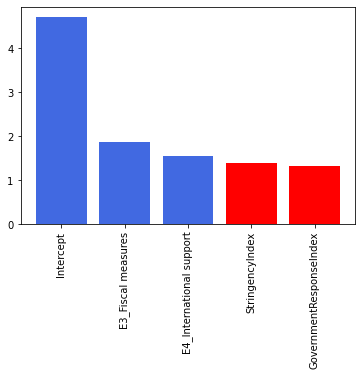

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept     4.703599
85                       Country_Iran     1.867592
89                      Country_Italy     1.560273
83                      Country_India    -1.387733
118               Country_New Zealand    -1.330103
205             E1_Income support_2.0     1.294361
50                      Country_China     1.237338
164  Country_United States of America    -1.122396
203             E1_Income support_0.0    -1.043147
168                   Country_Vietnam    -0.968755

Bias: 0.48
Mean squared error: 3.19
RSS: 6746.58
Variance score: 0.74

R2 score: 0.50

                                   Feature   Coefficient
0                                Intercept -4.413952e+10
99                         Country_Lesotho -1.861961e+10
67                        Country_Eswatini -1.725233e+10
164       Country_Unit

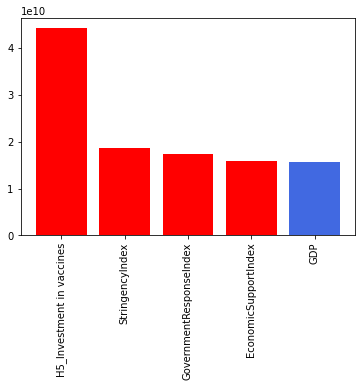

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                      Feature   Coefficient
0                                   Intercept -4.413952e+10
99                            Country_Lesotho -1.861961e+10
67                           Country_Eswatini -1.725233e+10
164          Country_United States of America -1.579303e+10
189             C5_Close public transport_1.0  1.574465e+10
190             C5_Close public transport_2.0  1.574465e+10
188             C5_Close public transport_0.0  1.574465e+10
144                      Country_South Africa -1.335560e+10
104                        Country_Madagascar  1.305067e+10
197  C7_Restrictions on internal movement_2.0  1.236305e+10

Bias: 0.48
Mean squared error: 3.17
RSS: 6721.38
Variance score: 0.74

R2 score: 0.50



In [28]:
weeks_for_cv = [0,1,2,3,4,5,6]
n_weeks_prediction = 2
results = {}
for i in weeks_for_cv:
    shorter_df = pipeline.cut_df_on_weeks(df, i)
    df_train, df_test = pipeline.split_and_scale_on_last_weeks(shorter_df, n_weeks_prediction)
    pipeline.sanity_check(df_train, df_test)
    X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
    X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
    dct = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)
    results['Until week: ' +str(i)] = dct

In [30]:
# summarizing time seried nested Cross Validation: 

metrics_r2 = pd.DataFrame(columns=['Lasso','Ridge','Linear Regression'])
for i, mkey in enumerate(results):
    for key in results[mkey]:
        metrics_r2.loc[i,key] = results[mkey][key][4]
metrics_r2

,Lasso,Ridge,Linear Regression
0,0.240668,0.705635,0.711498
1,0.234197,0.652142,0.655792
2,0.212157,0.613722,0.614207
3,0.175027,0.592219,0.592698
4,0.107496,0.573138,0.577274
5,-0.0130593,0.537656,0.541881
6,-0.186007,0.497421,0.499299


In [31]:
# finding averages across all folds

print("Lasso 7 fold avg:", metrics_r2['Lasso'].mean())
print("Ridge 7 fold avg:", metrics_r2['Ridge'].mean())
print("Linear Regression 7 fold avg:", metrics_r2['Linear Regression'].mean() )

Lasso 7 fold avg: 0.1100684540591828
Ridge 7 fold avg: 0.5959905626535867
Linear Regression 7 fold avg: 0.5989499944915565


In [32]:
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)

In [34]:
predictions = pipeline.predictions_every_country(X_test.columns[19:171], X_test, y_pred, y_test)

In [35]:
predictions.to_pickle("../predictions/lreg_log_deaths.pkl")
pickle.dump(lreg, open("../trained_classifiers/lreg_log_deaths.pkl", 'wb'))